# Collaborative Filtering

Steps: 
1. Select users (neighbors) that have common rated items with the active user
2. Calculate the similarities between all neighbors and the active user
3. Make the estimation by similarity of the neighbors of the active user
4. Catch the most similar top-k neighbors
5. Calculate the estimated rating of the active user using the chosen top-k

Parameters: 
- Number of shared items when establishing similarity
- Similarity function
- k: how many neighoburs picked
- Normalization when aggregating by neighbours

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, KFold, train_test_split
from surprise.accuracy import rmse

from surprise import SVD, SVDpp, SlopeOne, NMF, CoClustering

import random
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

In [3]:
ratings = pd.read_csv("./Data/ratings_v2.csv")
ratings = ratings.drop('timestamp', axis=1)

## EDA & Preprocessing

__Ratings for Each Movie__

<AxesSubplot:>

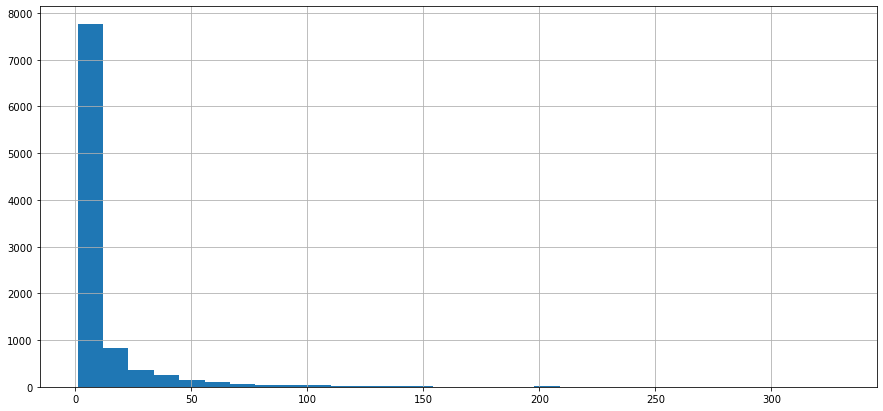

In [4]:
ratings.movieId.value_counts().hist(bins=30)

In [5]:
ratings.movieId.value_counts().value_counts().head(10)

1     3446
2     1298
3      800
4      530
5      382
6      319
7      278
8      230
9      172
11     154
Name: movieId, dtype: int64

As we can see, a lot of movies were rated only once. This is a problem for collaborative filtering, as it relies on a big database in order to actually work. All predictions for movies with one rating will be the one rating already in training. Moreover, if some of those movies are in the test set, then it will be impossible to predict

In [6]:
one_rating = (ratings.movieId.value_counts() == 1).reset_index()
one_rating.columns = ['movieId', 'movies_one_rating']
ratings = ratings.merge(one_rating, how='left', on='movieId')

## Modelling

Take away movies with only one rating: 

In [7]:
ratings = ratings[~ratings.movies_one_rating]

In [8]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.25)

In [9]:
# reader = Reader(rating_scale=(1, 5))
# data = Dataset.load_from_df(ratings.loc[random.sample(sorted(ratings.index), 400), ['userId', 'movieId', 'rating']], reader)
# trainset, testset = train_test_split(data, test_size=.25)

Define the parameter grids

In [10]:
sim_options = {'name': ['cosine', 'msd', 'pearson', 'pearson_baseline'],
               'user_based':[False], 
               'min_support': [2, 8]} # Number of common items for similarity to be different from 0

knn_params = {'k':np.arange(30,51,5),
            'min_k':[1, 2, 4],
            'sim_options': sim_options}

svd_params = {'n_factors':[50,100,150],
              'n_epochs':[20,30],
              'lr_all':[0.005,0.01],
              'reg_all':[0.02,0.1]}

In [11]:
sim_options = {'name': ['cosine',],
               'user_based':[False], 
               'min_support': [2, 8]} # Number of common items for similarity to be different from 0

knn_params = {'k':np.arange(30,51,5),
            'min_k':[1, 2, 4],
            'sim_options': sim_options}

svd_params = {'n_factors':[50,100,150],
              'n_epochs':[20,30],
              'lr_all':[0.005,0.01],
              'reg_all':[0.02,0.1]}

Loop through models, optimizing the parameters to find the best one

In [ ]:
# Define Algorithms and Vaidation Scheme
models = (NormalPredictor, BaselineOnly, SlopeOne, CoClustering, # No Tuning
          KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, 
          SVD, SVDpp)

models = (NormalPredictor, KNNWithZScore)
kf = KFold(random_state=random_state)

# DataFrame to put results in
results = pd.DataFrame({"RMSE":None, 
                        "MAE":None, 
                        "Fit Time": None, 
                        "Test Time": None, 
                        "Parameters":None}, index=[model.__name__ for model in models])

# Optimize and train all models
for model in models:
    print(f'Training {model.__name__}...')
    if model.__name__ in ('NormalPredictor', 'BaselineOnly', 'SlopeOne', 'CoClustering'): 
        out = cross_validate(model(), data, ['rmse', 'mae'], kf)
        results.loc[model.__name__] = [round(np.mean(out['test_rmse']), 2), 
                                       round(np.mean(out['test_mae']), 2),
                                       round(np.mean(out['fit_time']), 2),
                                       round(np.mean(out['test_time']), 2), 
                                       None]
        continue
    elif model.__name__ [:3]== 'KNN':
        tuned = GridSearchCV(model, knn_params, ['rmse', 'mae'], 5, n_jobs=-1)
    else: 
        tuned = GridSearchCV(model, svd_params, ['rmse', 'mae'], 5, n_jobs=-1)
    tuned.fit(data)
    best_index = tuned.best_index['rmse']
    cv_results = tuned.cv_results
    results.loc[model.__name__] = [round(cv_results['mean_test_rmse'][best_index], 2), 
                                   round(cv_results['mean_test_rmse'][best_index], 2), 
                                   round(cv_results['mean_fit_time'][best_index], 2),
                                   round(cv_results['mean_test_time'][best_index], 2),
                                   cv_results['params'][best_index]]

Training NormalPredictor...
Training KNNWithZScore...


In [308]:
# results.to_csv('./Data/results_collab_filtering_1.csv')